In [268]:
from Images import Images
from SIFT import SIFT
from Matcher import Matcher
from CV import CvHelper
from numpy.polynomial.polynomial import Polynomial
from FundamentalMat import FundamentalMat

import cv2
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [269]:
imgs = Images()
imgs.read_imgs_from_folder("buddha_images/", resize_factor = 1, show_imgs=False)

sift = SIFT()
sift.create_detector()
keypoints, descriptors = sift.detect_keypoints(imgs.gray, imgs.num_imgs, plot=False)

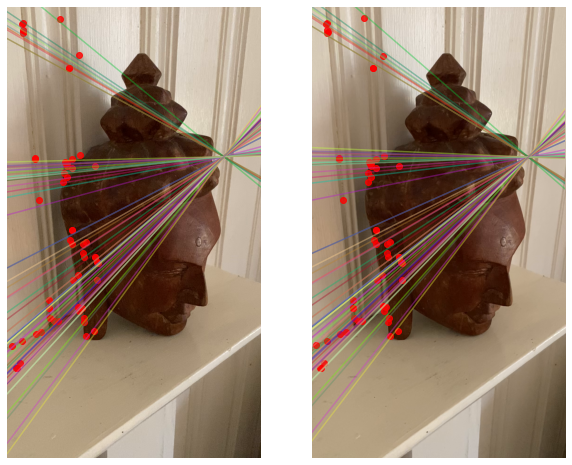

In [280]:
%matplotlib inline

cv_helper = CvHelper()
cv_helper.set_intrinsic_matrix(fx=2000, fy=2000, cx=0, cy=0)

matcher = Matcher(imgs=imgs.rgb, keypoints=keypoints, descriptors=descriptors)

for idx in range(0, 1):
    src_idx = idx
    dst_idx = idx + 1

    src_points, dst_points, good_matches = matcher.match_features(src_idx, dst_idx, plot = False)
    
    F_, inlier_mask_F, src_inliers_F, dst_inliers_F = cv_helper.get_fundamental_mat(src_points, dst_points)
    # F, inlier_mask_F, src_inliers_F, dst_inliers_F = cv_helper.get_fundamental_mat(imgs.shape, src_points, dst_points)
    F = FundamentalMat.seven_point_algorithm(src_points,
                                     dst_points)
    cv_helper.draw_epipolar_lines(src_inliers_F, dst_inliers_F, F, imgs.rgb[src_idx], imgs.rgb[dst_idx], max_lines = 60)

    E = cv_helper.get_essential_mat(F)

    P, src_inliers_P, dst_inliers_P = cv_helper.get_projection_matrix(E, src_inliers_F, dst_inliers_F)

    cv_helper.update_cv_container(src_idx, dst_idx, F, E, P)
    cv_helper.update_pt_container(src_idx, dst_idx, src_inliers_F, dst_inliers_F)

In [30]:
K = np.array([[2000,   0,     1920/2],
              [  0,   2000,   1080/2],
              [  0,    0,       1   ]])

poses = [np.vstack((np.hstack((np.eye(3), np.zeros((3, 1)))), [0,0,0,1]))]

for idx in range(imgs.num_imgs-1):
    F = cv_helper.cv_container[(idx, idx+1)]["F"]
    src = cv_helper.pt_container[(idx, idx+1)]["src"]
    dst = cv_helper.pt_container[(idx, idx+1)]["dst"]
    E = K.T @ F @ K
    _, R, t, mask = cv2.recoverPose(E, src, dst, K)
    poses.append(poses[idx] @ np.vstack((np.hstack((R, t)), [0,0,0,1])))

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib tk
def plot_camera(ax, R, t, scale=1, label=""):
    # Camera origin (the position of the camera in world coordinates)
    camera_center = R.T @ -t
    
    # Axes in the camera frame (local frame)
    x_axis = R.T @ np.array([1, 0, 0]) * scale
    y_axis = R.T @ np.array([0, 1, 0]) * scale
    z_axis = R.T @ np.array([0, 0, 1]) * scale
    
    # Convert arrays to dtype=object to avoid the deprecation warning
    camera_center = np.array(camera_center).reshape(-1)  # Ensure it's a flat array
    x_axis = np.array(x_axis).reshape(-1)
    y_axis = np.array(y_axis).reshape(-1)
    z_axis = np.array(z_axis).reshape(-1)
    
    # Plot the camera origin
    ax.scatter(*camera_center, c='r', marker='o')
    ax.text(*camera_center, label, color='blue')
    
    # Plot the axes
    ax.quiver(*camera_center, *x_axis, color='r', arrow_length_ratio=0.1)
    ax.quiver(*camera_center, *y_axis, color='g', arrow_length_ratio=0.1)
    ax.quiver(*camera_center, *z_axis, color='b', arrow_length_ratio=0.1)

# Visualization
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for idx, P in enumerate(poses):
    plot_camera(ax, P[:3, :3], P[:3,3], label=f"cam_{idx+1}")
# Set plot limits and labels
ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])
ax.set_zlim([-10, 10])
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title('Camera Poses Visualization')

plt.show()
